In [17]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista

In [18]:
import torch
import matplotlib.pyplot as plt
from utils import DelaunayTransform
from torch_geometric.data import Data
import networkx as nx
import pyvista as pv
import numpy as np

In [19]:
import random

N = 1_000
pos = torch.rand((N, 2))
data = Data(pos=pos[:, :2], surf=torch.full((N, 1), False))
transform = DelaunayTransform()
data = transform(data)
data.pos = pos

data = torch.load('./sampleData.pth')

def plot_graph(data, l=1, plotter=None):
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    mesh = pv.PolyData()
    mesh.points = np.concatenate([data.pos.numpy(), np.full((data.pos.shape[0], 1), l)], axis=1) 
    edges = data.edge_index.t().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    le = len(p.meshes) if p.meshes is None else 0
    p.add_mesh(mesh, line_width=1, color=c[le])
    
    if plotter is None:
        p.show()

/home/dimitri/anaconda3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


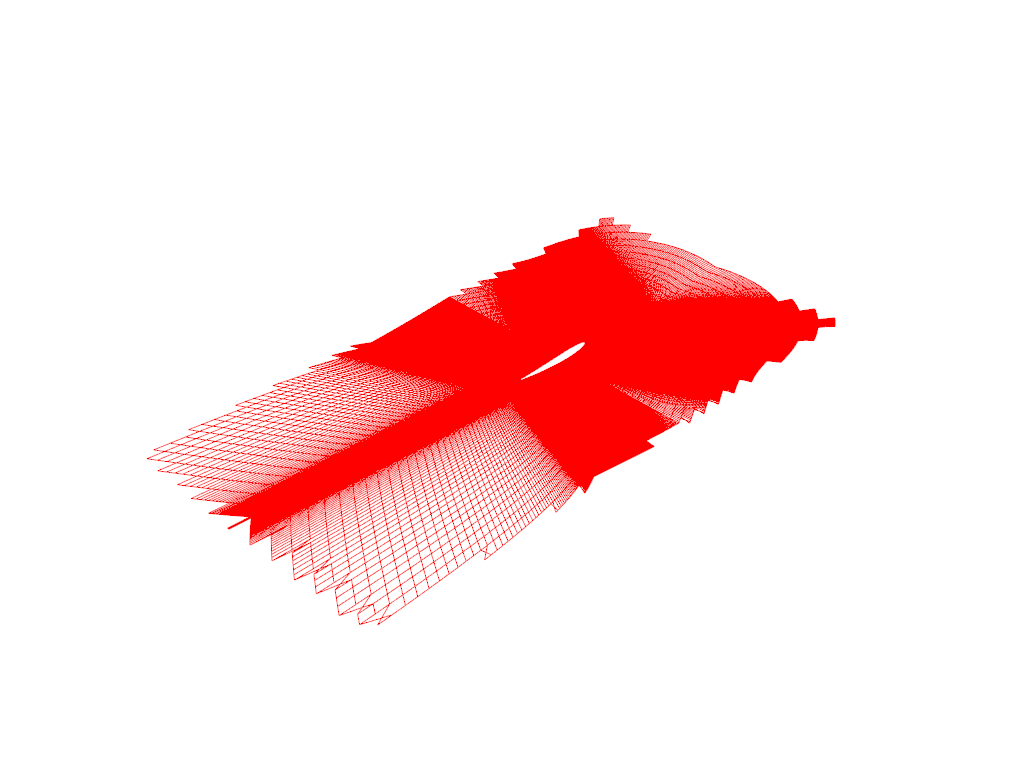

In [20]:
plot_graph(data)

In [21]:
import time

def divide_mesh(v, e, k):
    clusters = [Data(edge_ids=set()) for _ in range(k)]
    
    # Randomly initialize centroids (2D points)
    centroids = torch.rand((k, 2), device=v.device)

    # Precompute edge directions and norms
    edges_directions = v[e[:, 1]] - v[e[:, 0]]
    edges_norms = torch.norm(edges_directions, dim=1, keepdim=True)  # Shape: [num_edges, 1]
    edges_directions /= edges_norms  # Normalize edge directions
    start_all = time.time()
    norm_changes = float('inf')
    while norm_changes > 1e-3:
        # Vectorized clustering step
        centroids_norms = torch.norm(centroids, dim=1, keepdim=True)  # Shape: [num_centroids, 1]
        cosine_angles = torch.matmul(edges_directions, centroids.T) / (centroids_norms.T)  # Shape: [num_edges, num_centroids]
        angles = torch.acos(cosine_angles)  # Ensure values are in valid range for acos
        min_edge_idxs = torch.argmin(angles, dim=1)  # Shape: [num_edges]
        # Efficient assignment to clusters using torch
        cluster_masks = [(min_edge_idxs == i) for i in range(k)]
        for i in range(k):
            clusters[i].edge_ids.update(torch.nonzero(cluster_masks[i]).squeeze(1).tolist())

        # Efficient centroid update
        n_m = 0.0
        for i in range(k):
            if clusters[i].edge_ids:  # Check if the cluster has assigned edges
                cluster_edges = edges_directions[torch.tensor(list(clusters[i].edge_ids), device=v.device)]
                last_centroid = centroids[i].clone()
                centroids[i] = torch.mean(cluster_edges, dim=0)
                n_m = max(torch.norm(centroids[i] - last_centroid), n_m)
        norm_changes = n_m

    print("All:", time.time() - start_all)

    # Post-process clusters to finalize edge indices
    for cluster in clusters:
        cluster.edge_index = e[list(cluster.edge_ids)]
        del cluster.edge_ids

    return clusters


device = torch.device('cpu')
data.pos = data.pos[:, :2].to(device) 
clusters = divide_mesh(data.pos, data.edge_index.T, 8)
clusters

All: 0.8974921703338623


[Data(edge_index=[90199, 2]),
 Data(edge_index=[14047, 2]),
 Data(edge_index=[15562, 2]),
 Data(edge_index=[33735, 2]),
 Data(edge_index=[43079, 2]),
 Data(edge_index=[14030, 2]),
 Data(edge_index=[10485, 2]),
 Data(edge_index=[232144, 2])]

In [24]:
from sklearn.cluster import KMeans

def generate_coarse_graph_with_clustering(g, num_clusters):
    """
    Génère un graphe plus grossier à partir d'un graphe donné en utilisant K-means clustering
    pour réduire le nombre de sommets.
    
    :param g: Graphe de départ (de type torch_geometric Data).
    :param num_clusters: Le nombre de clusters ou "super-sommets" à créer.
    :return: Un nouveau graphe grossier avec moins de sommets et ajustement des arêtes.
    """
    pos = g.pos.cpu().numpy()  
    edges = g.edge_index.cpu().numpy() 
    
    # Appliquer K-means pour regrouper les points en 'num_clusters' clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pos)
    cluster_centers = kmeans.cluster_centers_  # Ce sont les nouveaux "super-sommets"
    labels = kmeans.labels_  # Chaque sommet est assigné à un cluster

    # Créer les nouvelles arêtes en connectant les clusters si un lien existe entre deux sommets dans l'ancien graphe
    new_edges = set()
    for edge in edges.T:  # On parcourt chaque arête
        cluster_u = labels[edge[0]]  # Le cluster du premier sommet
        cluster_v = labels[edge[1]]  # Le cluster du deuxième sommet
        
        if cluster_u != cluster_v:  # On ne connecte pas un cluster à lui-même
            new_edges.add((min(cluster_u, cluster_v), max(cluster_u, cluster_v)))

    # Convertir les nouvelles arêtes en un format utilisable (torch tensor)
    new_edges = np.array(list(new_edges)).T
    new_edges = torch.tensor(new_edges, dtype=torch.long)
    
    # Convertir les centres de clusters en tensor
    new_pos = torch.tensor(cluster_centers, dtype=torch.float)

    # Créer un nouveau graphe grossier avec les nouveaux sommets et les nouvelles arêtes
    coarse_graph = Data(pos=new_pos, edge_index=new_edges)
    
    return coarse_graph
p = pv.Plotter()
plot_graph(data, 1)
print("Generating coarse graph with clustering...")
g3 = generate_coarse_graph_with_clustering(data, int(len(data.pos) // 10))
print("G3 done")
plot_graph(g3, 1.0)
g2 = generate_coarse_graph_with_clustering(g3, int(len(g3.pos) // 10))
plot_graph(g2, 1.0)
g1 = generate_coarse_graph_with_clustering(g2, int(len(g2.pos) // 10))
plot_graph(g1, 1.0)


/home/dimitri/anaconda3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


KeyboardInterrupt: 